# SIGN Recognizer

In this notebook we will implement a convolutional neural network in TensorFlow to recognize images from the SIGN dataset, which is comprised of hand gestures images that represent numbers from 0 to 5.

## Preliminaries

Let's import the libraries we will use.

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from helpers import *

%matplotlib inline
np.random.seed(1)

## Loading Dataset

Let's proceed to load the dataset:

In [2]:
X_train, y_train, X_test, y_test, classes = load_dataset()

Let's now take a look at some of our instances:

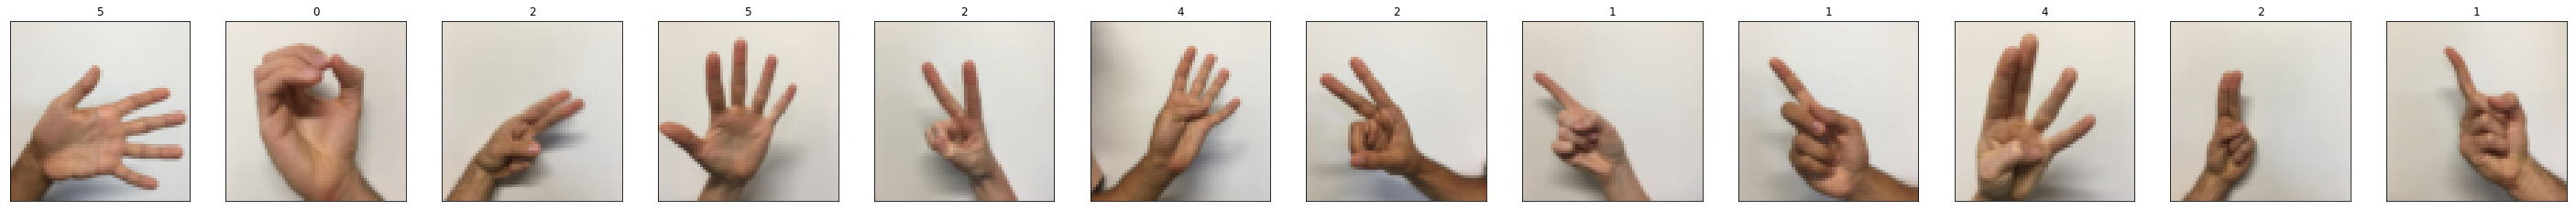

In [3]:
SAMPLE_SIZE = 12

# Plot the images in the sample
figure = plt.figure(figsize=(50, 50))

for sample_index in range(SAMPLE_SIZE):
    ax = figure.add_subplot(1, SAMPLE_SIZE, sample_index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[sample_index])
    ax.set_title(np.squeeze(y_train[:, sample_index]))

## Preprocess Data

Good. Let's preprocess our examples by normalizing them (we'll divide each pixel by 255) and our labels by one-hot encoding them:

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

NUMBER_OF_CLASSES = 6
y_train = one_hot_encode(y_train, NUMBER_OF_CLASSES).T
y_test = one_hot_encode(y_test, NUMBER_OF_CLASSES).T

Let's print some general information about the dataset:

In [5]:
print(f'Number of training examples: {len(X_train)}')
print(f'Number of test examples: {len(X_test)}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

Number of training examples: 1080
Number of test examples: 120
X_train shape: (1080, 64, 64, 3)
y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
y_test shape: (120, 6)


## Creating placeholders

TensorFlow needs that we create placeholders for the data that will be processed by the model. 

Let's implement a function to do this:

In [9]:
def create_placeholders(input_height, input_width, input_channels, number_of_classes):
    X = tf.placeholder(tf.float32, shape=(None, input_height, input_width, input_channels))
    y = tf.placeholder(tf.float32, shape=(None, number_of_classes))
    
    return X, y

We can test this function as follows:

In [10]:
X, y = create_placeholders(64, 64, 3, 6)

print(f'X: {X}')
print(f'y: {y}')

X: Tensor("Placeholder_1:0", shape=(?, 64, 64, 3), dtype=float32)
y: Tensor("Placeholder_2:0", shape=(?, 6), dtype=float32)


## Parameters Initialization

Given we are building a two-layered CNN, we need a way to initialize the two weight matrices our model will use.

In [11]:
def initialize_parameters(w1_shape=(4, 4, 3, 8), w2_shape=(2, 2, 8, 16)):
    tf.set_random_seed(1)
    
    w1 = tf.get_variable('W1', w1_shape, initializer=tf.contrib.layers.xavier_initializer(seed=0))
    w2 = tf.get_variable('W2', w2_shape, initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    return {'W1': w1, 'W2': w2}
    

Testing this function is a bit more cumbersome:

In [13]:
tf.reset_default_graph()

with tf.Session() as s:
    parameters = initialize_parameters()
    
    initializer = tf.global_variables_initializer()
    
    s.run(initializer)
    
    print(f'W1: {parameters["W1"].eval()[1, 1, 1]}')
    print(f'W2: {parameters["W2"].eval()[1, 1, 1]}')

W1: [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2: [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## Forward Propagation

We will implement the following architecture: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. We'll rely on the functions defined before. 

In detail, we will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. We won't call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which we'll call in a different function when computing the cost. 

In [14]:
def forward_propagation(X, parameters):
    # Unpack relevant parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # Conv2D: stride 1, padding is "SAME"
    out = tf.nn.conv2d(X, W1, stride=[1, 1, 1, 1], padding='SAME')
    # RELU
    out = tf.nn.relu(out)
    # Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
    out = tf.nn.max_pool(out, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
    
    # Conv2D: stride 1, padding is "SAME"
    out = tf.nn.conv2d(out, W2, stride=[1, 1, 1, 1], padding='SAME')
    # RELU
    out = tf.nn.relu(out)
    # Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
    out = tf.nn.max_pool(out, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    
    # Flatten
    out = tf.contrib.layers.flatten(out)

    # Fully-connected
    out = tf.contrib.layers.fully_connected(out, NUMBER_OF_CLASSES, activation_fn=None)
    return out

Another tricky test run is ahead: